In [1]:
import torch
import pickle
import numpy as np
import torchvision.models as models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from generate_proposals import GenerateProposals
from roi_align import RoIAlignFunction, preprocess_rois
import utils.vis as vis_utils
import utils.visualize as visualize
import utils.result_utils as result_utils
import skimage.io as io
from utils.blob import prep_im_for_blob
import utils.dummy_datasets as dummy_datasets
from PIL import Image
get_ipython().magic(u'matplotlib inline')

In [2]:
R_101_FPN_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/35861858-R-101-FPN/model_final.pkl"
X_152_32x8d_FPN_IN5k_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/37129812-X-152-32x8d-FPN-IN5k/model_final.pkl"
R_101_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/R-101/R-101.pkl"
X_152_32x8d_IN5k_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/X-152-32x8d-IN5k/X-152-32x8d-IN5k.pkl"

R_50_C4_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/tmp/model_final.pkl"
R_50_PATH = "/home/at3577/driveME/src/fair-maskrcnn/models/tmp/R-50.pkl"

In [3]:
class ResnetModel(nn.Module):
    def __init__(self, backbone_architecture, pretrained_model_file, resnet_feature_extraction_layers=['conv1','bn1','relu','maxpool','layer1','layer2','layer3']):
        super(ResnetModel, self).__init__()
        
        
        self.resnet_model = eval('models.' + backbone_architecture + '()') # construct ResNet model (maybe not very safe :) 

        # swap stride (2,2) and (1,1) in first layers (PyTorch ResNet is slightly different to caffe2 ResNet)
        # this is required for compatibility with caffe2 models
        self.resnet_model.layer2[0].conv1.stride=(2,2)
        self.resnet_model.layer2[0].conv2.stride=(1,1)
        self.resnet_model.layer3[0].conv1.stride=(2,2)
        self.resnet_model.layer3[0].conv2.stride=(1,1)
        self.resnet_model.layer4[0].conv1.stride=(2,2)
        self.resnet_model.layer4[0].conv2.stride=(1,1)
        
        self.init_weights(pretrained_model_file)
        
        # All except the last layer are used as feature extractor... Last layer is for ROI pooling
        self.model = torch.nn.Sequential(*[getattr(self.resnet_model, layer) for layer in resnet_feature_extraction_layers])
        self.model.eval()
        
    def forward(self, image):
        return self.model(image)
    
    def init_weights(self, pretrained_model_file):
        with open(pretrained_model_file, 'rb') as model_pickle_file:
            fb_model = pickle.load(model_pickle_file)
            # Model has two keys- config and blobs
            fb_model = fb_model['blobs']
        
        model_dict = self.resnet_model.state_dict()
        
        for key in model_dict.keys():
            # skip running mean/std and fc weights
            # I am not sure what running is but fc is the last fuly connected layer of resnet.. so fb model doesnt have it
            if 'running' in key or 'fc' in key:
                continue
            
            fb_key = self.convert_key_to_fb_format(key.split('.'))
           
            assert model_dict[key].size()==torch.FloatTensor(fb_model[fb_key]).size()
            
            if key=='conv1.weight': # convert from BGR to RGB                
                model_dict[key]=torch.FloatTensor(fb_model[fb_key][:,(2, 1, 0),:,:])
            else:
                model_dict[key]=torch.FloatTensor(fb_model[fb_key])
        
        # update model
        self.resnet_model.load_state_dict(model_dict)

    def convert_key_to_fb_format(self, terms, i=0, parsed=''):
        # Convert PyTorch ResNet weight names to caffe2 weight names
        if i==0:
            if terms[i]=='conv1':
                parsed='conv1'
            elif terms[i]=='bn1':
                parsed='res_conv1'
            elif terms[i].startswith('layer'):
                parsed='res'+str(int(terms[i][-1])+1)
        else:
            if terms[i]=='weight' and (terms[i-1].startswith('conv') or terms[i-1]=='0'):
                parsed+='_w'
            elif terms[i]=='weight' and (terms[i-1].startswith('bn') or terms[i-1]=='1'):
                parsed+='_bn_s'
            elif terms[i]=='bias' and (terms[i-1].startswith('bn') or terms[i-1]=='1'):
                parsed+='_bn_b'
            elif terms[i-1].startswith('layer'):
                parsed+='_'+terms[i]
            elif terms[i].startswith('conv') or terms[i].startswith('bn'):
                parsed+='_branch2'+chr(96+int(terms[i][-1]))
            elif terms[i]=='downsample':
                parsed+='_branch1'
        # increase counter
        i+=1
        # do recursion
        if i==len(terms):
            return parsed
        return self.convert_key_to_fb_format(terms,i,parsed)

In [4]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, pretrained_model_file, feature_extractor_output_channels, rpn_conv_output_channels, number_of_anchors):
        super(RegionProposalNetwork, self).__init__()
        
        #RPN is used propose regions with probability of foreground/background.. i.e just tell if object is present
        # It has 3 parts:
        # 1) 3x3 conv with 512/1024 channels
        # 2) 1x1 conv with 2k channels (for each anchor box we predict foreground/background)
        # 3) 1x1 conv with 4k channels (for each anchor box we predict delta of boxes)
        
        self.conv_rpn = torch.nn.Conv2d(in_channels=feature_extractor_output_channels,
                                        out_channels=rpn_conv_output_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)
        self.rpn_cls_prob = torch.nn.Conv2d(in_channels=rpn_conv_output_channels,
                                            out_channels=number_of_anchors,
                                            kernel_size=1,
                                            stride=1,
                                            padding=0)
        self.rpn_bbox_pred = torch.nn.Conv2d(in_channels=rpn_conv_output_channels,
                                             out_channels=4*number_of_anchors,
                                             kernel_size=1,
                                             stride=1,
                                             padding=0)
        
        self.init_weights(pretrained_model_file)
        
    def forward(self, anchor_features):
        # image features shape should be (N,Cin,H,W)  
        conv_anchor_features = F.relu(self.conv_rpn(anchor_features))
        anchor_cls_prob =  F.softmax(self.rpn_cls_prob(conv_anchor_features))
        anchor_box_pred =  self.rpn_bbox_pred(conv_anchor_features)
        return anchor_cls_prob, anchor_box_pred

    def init_weights(self, pretrained_model_file):
        with open(pretrained_model_file, 'rb') as model_pickle_file:
            fb_model = pickle.load(model_pickle_file)
            # Model has two keys- config and blobs
            fb_model = fb_model['blobs']
        
            self.conv_rpn.weight.data = torch.FloatTensor(fb_model['conv_rpn_w'])
            self.conv_rpn.bias.data = torch.FloatTensor(fb_model['conv_rpn_b'])
            self.rpn_cls_prob.weight.data = torch.FloatTensor(fb_model['rpn_cls_logits_w'])
            self.rpn_cls_prob.bias.data = torch.FloatTensor(fb_model['rpn_cls_logits_b'])
            self.rpn_bbox_pred.weight.data = torch.FloatTensor(fb_model['rpn_bbox_pred_w'])
            self.rpn_bbox_pred.bias.data = torch.FloatTensor(fb_model['rpn_bbox_pred_b'])
        

In [5]:
#ROI_POOLING
class ROI_Pooling(nn.Module):
    def __init__(self, roi_height, roi_width, roi_spatial_scale, roi_sampling_ratio, conv_head_layers, resnet_model):
        super(ROI_Pooling, self).__init__()
        self.roi_height = roi_height
        self.roi_width  = roi_width
        self.roi_spatial_scale = roi_spatial_scale
        self.roi_sampling_ratio = roi_sampling_ratio
        self.conv_head = nn.Sequential(*[getattr(resnet_model, layer) for layer in conv_head_layers]) 
        
    def forward(self, img_features, rois):
        roi_features = RoIAlignFunction.apply(img_features, preprocess_rois(rois), self.roi_height, self.roi_width, self.roi_spatial_scale, self.roi_sampling_ratio)
        
        # compute 1x1 roi features
        roi_features = self.conv_head(roi_features) # 1x1 feature per proposal
        roi_features = roi_features.view(roi_features.size(0),-1)
        
        return roi_features

In [6]:
class RCNN(nn.Module):
    def __init__(self, pretrained_model_file, roi_feature_size, N_classes):
        super(RCNN, self).__init__()
        # What will be the size of roi_feature_channels??
        self.bbox_head=torch.nn.Linear(roi_feature_size, 4*N_classes)
        self.class_prob_head=torch.nn.Linear(roi_feature_size, N_classes)
        
        self.init_weights(pretrained_model_file)
    
    def forward(self, roi_features):
        # compute classification probabilities
        cls_score = self.class_prob_head(roi_features)
        cls_prob =  F.softmax(cls_score,dim=1)

        # compute bounding box parameters 
        bbox_pred = self.bbox_head(roi_features)
        
        return (cls_score,cls_prob,bbox_pred)
    
    def init_weights(self, pretrained_model_file):
        with open(pretrained_model_file, 'rb') as model_pickle_file:
            fb_model = pickle.load(model_pickle_file)
            # Model has two keys- config and blobs
            fb_model = fb_model['blobs']        
 
            self.class_prob_head.weight.data = torch.FloatTensor(fb_model['cls_score_w'])
            self.class_prob_head.bias.data = torch.FloatTensor(fb_model['cls_score_b'])

            self.bbox_head.weight.data = torch.FloatTensor(fb_model['bbox_pred_w'])
            self.bbox_head.bias.data = torch.FloatTensor(fb_model['bbox_pred_b'])

In [7]:
class Detector(nn.Module):
    def __init__(self,
                 backbone_architecture,
                 pretrained_model_file, 
                 resnet_feature_extraction_layers, 
                 feature_extractor_output_channels,
                 rpn_conv_output_channels,
                 number_of_anchors,
                 conv_head_layers,
                 roi_height,
                 roi_width,
                 roi_spatial_scale,
                 roi_sampling_ratio,
                 roi_feature_size,
                 N_classes):
        super(Detector, self).__init__() 
        
        self.backbone_architecture               = backbone_architecture
        self.pretrained_model_file               = pretrained_model_file     
        self.resnet_feature_extraction_layers    = resnet_feature_extraction_layers     
        self.feature_extractor_output_channels   = feature_extractor_output_channels    
        self.rpn_conv_output_channels            = rpn_conv_output_channels    
        self.number_of_anchors                   = number_of_anchors    
        self.conv_head_layers                    = conv_head_layers    
        self.roi_height                          = roi_height    
        self.roi_width                           = roi_width    
        self.roi_spatial_scale                   = roi_spatial_scale    
        self.roi_sampling_ratio                  = roi_sampling_ratio    
        self.roi_feature_size                    = roi_feature_size    
        self.N_classes                           = N_classes

        self.resnet_model = ResnetModel(backbone_architecture = backbone_architecture,
                                        pretrained_model_file= pretrained_model_file,
                                        resnet_feature_extraction_layers= resnet_feature_extraction_layers)
        
        self.rpn = RegionProposalNetwork(pretrained_model_file= pretrained_model_file,
                                         feature_extractor_output_channels= feature_extractor_output_channels,
                                         rpn_conv_output_channels= rpn_conv_output_channels,
                                         number_of_anchors= number_of_anchors)
        self.proposal_generator = GenerateProposals(train=False)
        
        self.roi_pooling = ROI_Pooling(roi_height, roi_width, roi_spatial_scale, roi_sampling_ratio, conv_head_layers, self.resnet_model.resnet_model)
        
        self.rcnn = RCNN(pretrained_model_file, roi_feature_size, N_classes)
       
    def forward(self, image, scaling_factor=None):
        h,w = image.size(2), image.size(3)

        img_features = self.resnet_model(image)
        
        print 'Image features size ' + str(img_features.shape)
        
        print 'Number of channels should match ' + str(self.feature_extractor_output_channels)
        
        rpn_cls_prob, rpn_bbox_pred = self.rpn(img_features)
        
        print 'RPNs class ' + str(rpn_cls_prob.shape)
        print 'RPNs box ' + str(rpn_bbox_pred.shape) 
        
        rois, rpn_roi_probs = self.proposal_generator(rpn_cls_prob, rpn_bbox_pred, h, w, scaling_factor)
        
        print 'ROIS ' + str(rois.shape)
        
        roi_features = self.roi_pooling(img_features, rois)
        
        print 'After ROI Pooing ' + str(roi_features.shape)
        print 'This should match ' + str(self.roi_feature_size) 
        
        cls_score,cls_prob,bbox_pred = self.rcnn(roi_features)
        
        print 'Final class ' + str(cls_score.shape) 
        print 'Final box ' + str(bbox_pred.shape) 
        
        return (cls_score,cls_prob,bbox_pred,rois,img_features,rpn_roi_probs)

In [8]:
model =  Detector(backbone_architecture='resnet50',
                 pretrained_model_file = R_50_C4_PATH, 
                 resnet_feature_extraction_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3'], 
                 feature_extractor_output_channels = 1024,
                 rpn_conv_output_channels = 1024,
                 number_of_anchors = 15,
                 conv_head_layers = ['layer4','avgpool'],
                 roi_height = 14,
                 roi_width = 14,
                 roi_spatial_scale = 0.0625,
                 roi_sampling_ratio = 0,
                 roi_feature_size = 2048,
                 N_classes = 81)

In [9]:
def eval_model(sample):
    class_scores, cls_prob, bbox_deltas, rois, img_features,rpn_roi_probs = model(sample['image'],
                                                         scaling_factor=sample['scaling_factors'].cpu().data.numpy().item())   
    return class_scores, cls_prob, bbox_deltas,rois,img_features,rpn_roi_probs

In [10]:
#image_filename = 'demo/33823288584_1d21cf0a26_k.jpg'
image_filename = 'demo/19064748793_bb942deea1_k.jpg'

# Load image
image = io.imread(image_filename)
orig_im_size = image.shape

# Preprocess image
im_list, im_scales = prep_im_for_blob(image)

# Build sample
sample = {}
sample['image'] = Variable(torch.FloatTensor(im_list[0]).permute(2,0,1).unsqueeze(0))
sample['scaling_factors'] = Variable(torch.FloatTensor([im_scales[0]]))
sample['original_im_size'] = Variable(torch.FloatTensor(orig_im_size))

class_scores, cls_prob,bbox_deltas,rois,img_features,rpn_roi_probs = eval_model(sample)

Image features size torch.Size([1, 1024, 50, 75])
Number of channels should match 1024


/share/apps/python/2.7.12/intel/lib/python2.7/site-packages/ipykernel/__main__.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RPNs class torch.Size([1, 15, 50, 75])
RPNs box torch.Size([1, 60, 50, 75])
ROIS torch.Size([1000, 4])
After ROI Pooing torch.Size([1000, 2048])
This should match 2048
Final class torch.Size([1000, 81])
Final box torch.Size([1000, 324])


In [16]:
# postprocess output:
# - convert coordinates back to original image size, 
# - treshold proposals based on score,
# - do NMS.
scores_final, boxes_final, boxes_per_class = result_utils.postprocess_output(rois,
                                                                            sample['scaling_factors'],
                                                                            sample['original_im_size'],
                                                                            cls_prob,
                                                                            bbox_deltas)

In [71]:
sample['image'].shape

torch.Size([1, 3, 800, 1275])

In [69]:
orig_im_size

(600, 956, 3)

In [16]:
sample['scaling_factors']

Variable containing:
 1.3333
[torch.FloatTensor of size 1]

In [17]:
rpn_roi_probs[:20]

Variable containing:
 0.9955
 0.9944
 0.9913
 0.9890
 0.9885
 0.9865
 0.9841
 0.9837
 0.9826
 0.9816
 0.9815
 0.9783
 0.9779
 0.9772
 0.9747
 0.9731
 0.9722
 0.9722
 0.9716
 0.9713
[torch.FloatTensor of size 20x1]

In [18]:
rois[0:2,:]

Variable containing:
   18.2432     0.0000  1089.7224   308.7288
 1043.1077   279.2000  1053.8765   298.9059
[torch.FloatTensor of size 2x4]

('Positive ROIs: ', 0)
('Negative ROIs: ', 10)
Positive Ratio: 0.00


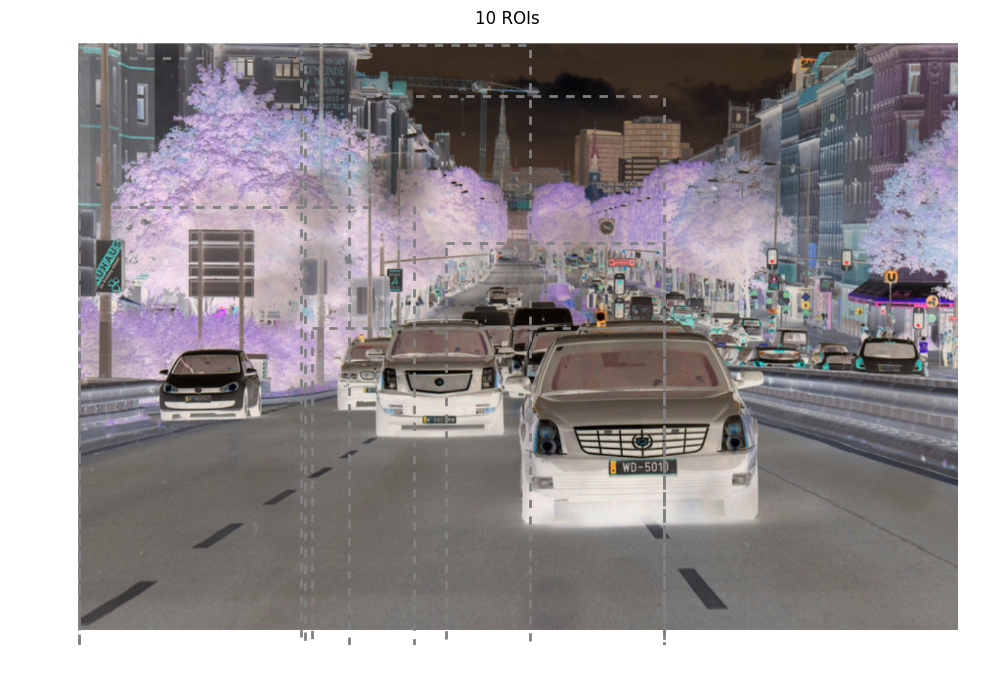

In [20]:
scaled_image = sample['image'].data[0].permute(1,2,0).numpy()
pixel_means=np.array([122.7717, 115.9465, 102.9801]).reshape((1,1,3))
scaled_image = scaled_image + pixel_means
scaled_image = scaled_image.astype(int)


visualize.draw_rois(scaled_image, rois[0:10,:], None, None, np.zeros(10), None, 10)

In [17]:
scores_final

array([], dtype=float32)

In [18]:
boxes_per_class

[[],
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], 

result saved to ./19064748793_bb942deea1_k.jpg.pdf


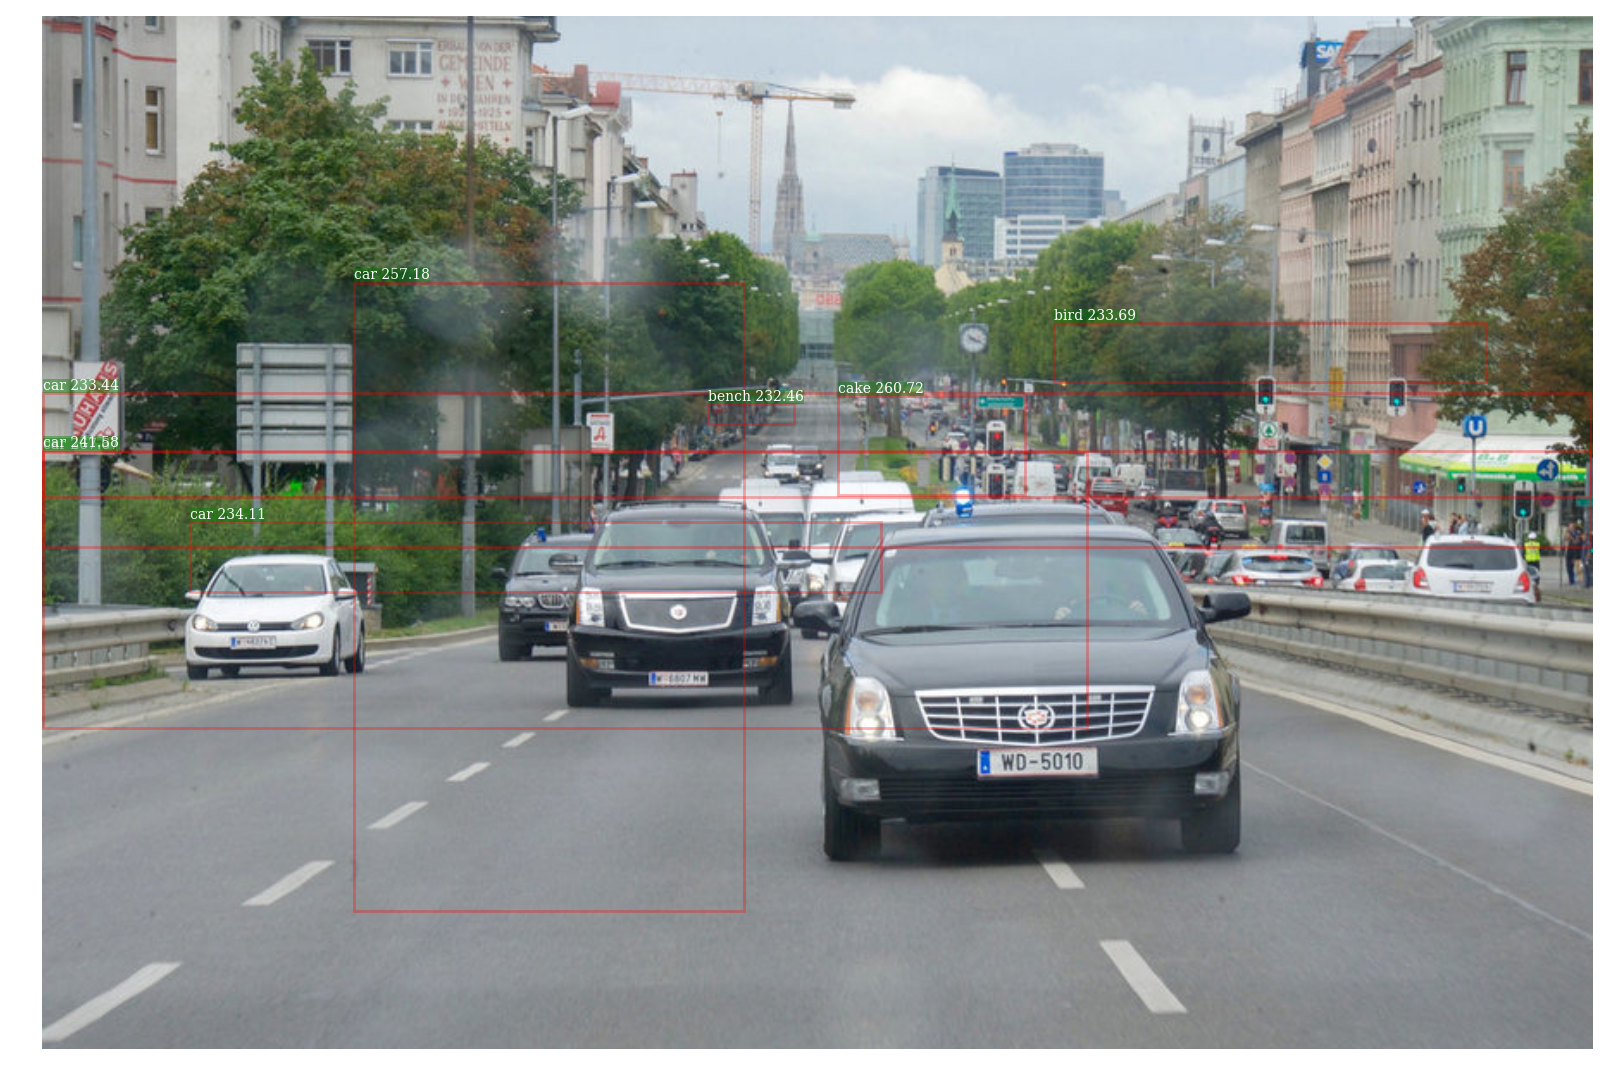

In [13]:
vis_utils.vis_one_image(
    image,  # BGR -> RGB for visualization
    image_filename,
    '.',
    boxes_per_class,
    None,
    None,
    dataset=dummy_datasets.get_coco_dataset(),
    box_alpha=0.3,
    show_class=True,
    thresh=0.7,
    kp_thresh=2,
    show=True
)

In [90]:
ans

[[], array([[ 707.30560303,  199.85507202,  724.61004639,  306.49707031,
          327.07052612],
        [ 448.02011108,    0.        ,  955.        ,  599.        ,
          324.19842529],
        [ 687.58288574,    0.        ,  806.74389648,  599.        ,
          323.74560547],
        [   0.        ,  599.        ,  955.        ,  599.        ,
          317.45233154],
        [   0.        ,    0.        ,  955.        ,    0.        ,
          316.67941284],
        [ 285.4258728 ,  477.05541992,  955.        ,  599.        ,
          316.22320557],
        [ 908.85681152,  574.62060547,  955.        ,  599.        ,
          304.45092773],
        [ 697.03479004,  263.62667847,  744.02038574,  324.45046997,
          303.07647705],
        [ 706.52471924,  137.33432007,  723.68536377,  276.53161621,
          301.56106567],
        [   0.        ,  214.06910706,  955.        ,  599.        ,
          300.86730957]], dtype=float32), array([], shape=(0, 5), dtype=float32),

In [21]:
cls_prob.shape[0]

1000L

In [32]:
for i in range(cls_prob.shape[0]):
    if cls_prob[i][0].data[0] == 1:
        print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [38]:
np.argmax(class_scores.data.numpy(),axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [44]:
F.softmax(class_scores[0],dim=0)

Variable containing:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 81]

In [46]:
m = nn.Softmax()
input = Variable(torch.randn(2, 3))
output = m(input)

/share/apps/python/2.7.12/intel/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [47]:
output

Variable containing:
 0.2889  0.0715  0.6396
 0.5835  0.1868  0.2298
[torch.FloatTensor of size 2x3]

In [48]:
torch.nn.Softmax(dim=1)(class_scores)

Variable containing:
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 1.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 1000x81]

In [50]:
class_scores[0].

Variable containing:
 367.6566
 167.8344
 -39.7643
 -60.1863
 -63.1627
 -74.9807
 -71.1062
 -45.6398
 -73.4174
 -23.3274
 -56.7414
 -24.5665
 -10.3485
 -25.3707
   6.5863
 105.8029
  89.8470
  43.0604
 -12.4117
 -57.8126
 -86.5434
 -53.9899
 -20.4707
 -46.7983
 -16.3696
  -8.4677
 101.6456
  55.5840
  27.8748
 -15.1188
 -24.6730
 -33.0377
 -54.8191
 -52.6724
   7.6647
 -56.7177
 -11.3385
 -55.0136
 -18.6562
 -23.6579
  59.3235
  -6.9696
  38.0991
 -17.5053
  -0.6373
 -26.9148
  45.9082
 -11.4663
 -17.2869
  26.9646
 -47.8036
 -21.6266
 -51.6717
 -50.9076
  21.0938
 -43.8009
  71.7519
  51.6531
  22.5742
  89.3164
  35.4315
  47.2787
   8.2041
  57.2191
  20.7790
 -52.8112
 -42.7839
 -56.0328
 -47.3505
 -12.4285
   8.4480
 -32.4268
  -5.9200
   8.5185
  83.1900
  -4.3492
  63.3920
  16.1142
  27.7184
  10.3942
 -21.2433
[torch.FloatTensor of size 81]